# Import Library & Port Forward

## Fetching Data from MySQL into a Pandas DataFrame

### Setup

Beberapa paket yang harus diinstall sebelum menjalankan program.
Anda bisa menginstall paket dibawah ini pada anaconda prompt atau jupyter notebook

paket `mysql-connector-python` untuk menyambung ke basis data MySQL dan paket `pandas` untuk bekerja dengan DataFrames
```bash
pip install mysql-connector-python
```

In [3]:
# install mysql connector di jupyter notebook
!pip install mysql-connector-python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import mysql.connector
from mysql.connector import Error

# import warning to ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fungsi untuk mengkoneksikan ke database
def connect_to_db(host_name, port_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            port=port_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

In [3]:
# define mysql details
host   = 'okegarden-laravel-prod-db-2024-11-15-0200.cgwhhgh85mr3.ap-southeast-3.rds.amazonaws.com'
port   = 3306
user   = 'intern_mes'
passwd = 'sdfDFLES342982Ddlsdksd'
databs = 'okegarden_laravel_prod_db'

In [4]:
# mencoba terkoneksi dengan database
connect_to_db(host, port, user, passwd, databs)

MySQL Database connection successful


## Writing the Function to Fetch Data

In [5]:
# berfungsi untuk mengambil data dari database, koneksi ditutup setelah digunakan.
def fetch_data(host_name, port_name, user_name, user_password, db_name, query, params=None):
    try:
        with mysql.connector.connect(
            host=host_name,
            port=port_name,
            user=user_name,
            password=user_password,
            database=db_name
        ) as connection:
            data = pd.read_sql(query, connection, params=params)
            return data

    except Error as e:
        print(f"Error while connecting to MySQL or fetching data: {e}")
        return None

# Assessing Data

In [6]:
# Mendefinisikan master query
master_query = """

SELECT
   DATE(order_garden.created_at) AS date,
   order_garden.id_order,
   order_garden.id_user,
   design.design_name,
   order_garden.size_area,
   CASE
       WHEN order_garden.price = 0 THEN order_garden.total_promo
       ELSE order_garden.price
   END AS revenue,
   desc_design.total_item_cost,
   CASE
       WHEN order_garden.size_area <= 10 THEN 2
       WHEN order_garden.size_area BETWEEN 11 AND 20 THEN 3
       WHEN order_garden.size_area BETWEEN 21 AND 30 THEN 4
       WHEN order_garden.size_area BETWEEN 31 AND 40 THEN 5
       WHEN order_garden.size_area BETWEEN 41 AND 50 THEN 5
       ELSE 5
   END AS jumlah_tenaga_kerja,
   CASE
       WHEN order_garden.size_area <= 10 THEN 2 * 250000
       WHEN order_garden.size_area BETWEEN 11 AND 20 THEN 3 * 250000
       WHEN order_garden.size_area BETWEEN 21 AND 30 THEN 4 * 250000
       WHEN order_garden.size_area BETWEEN 31 AND 40 THEN 5 * 250000
       WHEN order_garden.size_area BETWEEN 41 AND 50 THEN 5 * 250000
       ELSE 5 * 250000
   END AS total_biaya_tenaga_kerja,
   (CASE
       WHEN order_garden.size_area <= 10 THEN 2 * 250000
       WHEN order_garden.size_area BETWEEN 11 AND 20 THEN 3 * 250000
       WHEN order_garden.size_area BETWEEN 21 AND 30 THEN 4 * 250000
       WHEN order_garden.size_area BETWEEN 31 AND 40 THEN 5 * 250000
       WHEN order_garden.size_area BETWEEN 41 AND 50 THEN 5 * 250000
       ELSE 5 * 250000
   END + desc_design.total_item_cost) AS cogs,
   ((CASE
       WHEN order_garden.price = 0 THEN order_garden.total_promo
       ELSE order_garden.price
   END) -
   (CASE
       WHEN order_garden.size_area <= 10 THEN 2 * 250000
       WHEN order_garden.size_area BETWEEN 11 AND 20 THEN 3 * 250000
       WHEN order_garden.size_area BETWEEN 21 AND 30 THEN 4 * 250000
       WHEN order_garden.size_area BETWEEN 31 AND 40 THEN 5 * 250000
       WHEN order_garden.size_area BETWEEN 41 AND 50 THEN 5 * 250000
       ELSE 5 * 250000
   END + desc_design.total_item_cost)) AS gross_profit,
   order_garden.status,
   order_garden.id_gardener,
   u.name,
   address_components.administrative_area_level_1 AS province,
   address_components.administrative_area_level_2 AS city,
   address_components.administrative_area_level_3 AS district
FROM
   `order_garden`
JOIN
   `design` on design.id_design = order_garden.id_design_finish
LEFT JOIN
   (
       SELECT
           id_design,
           SUM(item_total_cost) AS total_item_cost
       FROM
           desc_design
       GROUP BY
           id_design
   ) desc_design ON design.id_design = desc_design.id_design
LEFT JOIN
   `user` u on order_garden.id_gardener = u.id_user
LEFT JOIN
   `address_components` on order_garden.id_order = address_components.address_componentable_id
WHERE
	order_garden.status != "expired"
	AND
	order_garden.id_user >= 250;

"""

In [7]:
# fetch data menggunakan fungsi
df = fetch_data(host, port, user, passwd, databs, master_query)

In [8]:
# menampilkan data
df.head()

,date,id_order,id_user,design_name,size_area,revenue,total_item_cost,jumlah_tenaga_kerja,total_biaya_tenaga_kerja,cogs,gross_profit,status,id_gardener,name,province,city,district
0,2024-04-23,65,927,Taman Regina,11.0,9230382.0,4463700.0,3,750000,5213700.0,4016682.0,in_review,1087.0,ODIH,Jakarta,East Jakarta City,Cakung
1,2024-04-27,66,926,Taman Susy,28.0,6581190.0,2646250.0,4,1000000,3646250.0,2934940.0,in_review,1093.0,Budi Wahyudi,Banten,South Tangerang City,Ciputat
2,2024-05-16,70,925,Taman Lintang R,35.0,11550859.0,3931899.0,5,1250000,5181899.0,6368960.0,finish,1085.0,Ari aryana,West Java,Bekasi,Pondok Melati
3,2024-05-24,72,1024,Taman Nopri,2.0,5440942.0,2987200.0,2,500000,3487200.0,1953742.0,finish,1087.0,ODIH,Banten,Tangerang Regency,Sindang Jaya
4,2024-06-12,74,1052,Taman Nur Atikah,5.0,4334875.0,2331500.0,2,500000,2831500.0,1503375.0,finish,1087.0,ODIH,Banten,Tangerang Regency,


In [9]:
# menampilkan informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      196 non-null    object 
 1   id_order                  196 non-null    int64  
 2   id_user                   196 non-null    int64  
 3   design_name               196 non-null    object 
 4   size_area                 196 non-null    float64
 5   revenue                   196 non-null    float64
 6   total_item_cost           196 non-null    float64
 7   jumlah_tenaga_kerja       196 non-null    int64  
 8   total_biaya_tenaga_kerja  196 non-null    int64  
 9   cogs                      196 non-null    float64
 10  gross_profit              196 non-null    float64
 11  status                    196 non-null    object 
 12  id_gardener               185 non-null    float64
 13  name                      185 non-null    object 
 14  province  

## Missing Values

In [10]:
# Mengecek jumlah nilai kosong di setiap kolom
df.isna().sum()

date                         0
id_order                     0
id_user                      0
design_name                  0
size_area                    0
revenue                      0
total_item_cost              0
jumlah_tenaga_kerja          0
total_biaya_tenaga_kerja     0
cogs                         0
gross_profit                 0
status                       0
id_gardener                 11
name                        11
province                     0
city                         0
district                     0
dtype: int64

## Duplicates

In [11]:
# Mengecek jumlah baris duplikat dalam dataframe
print("Jumlah duplikasi: ", df.duplicated().sum())

Jumlah duplikasi:  2


## Outliers

In [12]:
# Memilih kolom dengan tipe data numerik (integer dan float)
df_num = df.select_dtypes(include =['int64', 'float64'])

In [13]:
# Fungsi untuk menemukan outlier menggunakan metode IQR
def find_outlier(data):
    Q1 = np.quantile(data, .25)
    Q3 = np.quantile(data, .75)
    IQR = (Q3 - Q1) * 1.5
    lower_limit = Q1 - IQR
    upper_limit = Q3 + IQR

    outlier = ''
    for i in range(len(data)):
        if data[i] > upper_limit or data[i] < lower_limit:
            outlier += str(data[i]) + ', '

    return outlier

In [14]:
# Menampilkan jumlah outlier untuk setiap kolom numerik
for i in df_num:
    val = df_num[i].sort_values().values.tolist()
    print(f"Outliers Detected {i}: ", len(find_outlier(val)))

Outliers Detected id_order:  0
Outliers Detected id_user:  0
Outliers Detected size_area:  112
Outliers Detected revenue:  240
Outliers Detected total_item_cost:  260
Outliers Detected jumlah_tenaga_kerja:  60
Outliers Detected total_biaya_tenaga_kerja:  180
Outliers Detected cogs:  216
Outliers Detected gross_profit:  192
Outliers Detected id_gardener:  0


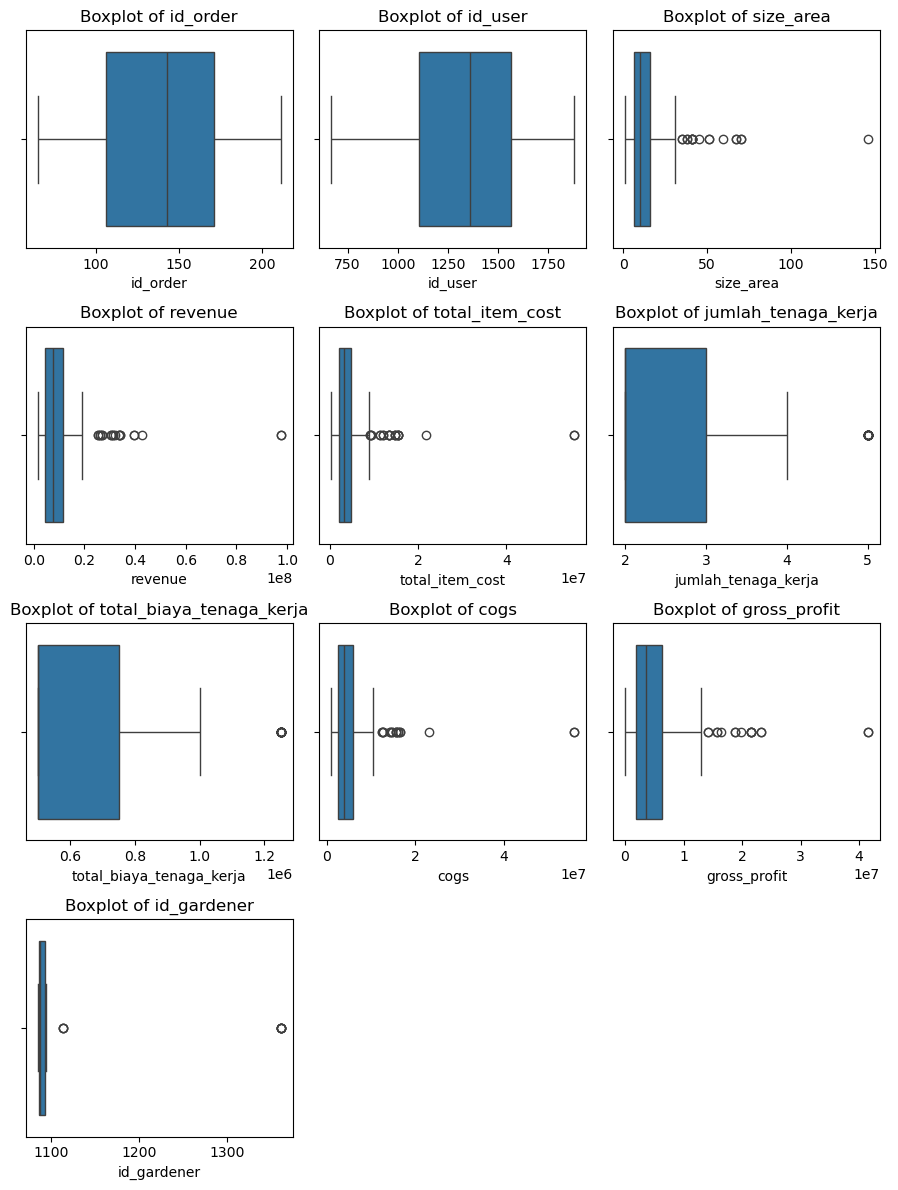

In [15]:
# Menampilkan boxplot untuk setiap kolom numerik dalam dataframe
num_cols = 3
num_rows = (len(df_num.columns) + num_cols - 1) // num_cols
plt.figure(figsize=(3 * num_cols, 3 * num_rows))

for i, column in enumerate(df_num.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(data=df_num, x=column)
    plt.title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

# Cleaning & Data Transformation

### Type casting

In [16]:
# Mengubah tipe data kolom sesuai kebutuhan
df['date'] = pd.to_datetime(df['date'])  # Mengubah 'date' menjadi datetime
df['revenue'] = df['revenue'].astype('int64')  # Mengubah 'revenue' menjadi integer
df['total_item_cost'] = df['total_item_cost'].astype('int64')  # Mengubah 'total_item_cost' menjadi integer
df['cogs'] = df['cogs'].astype('int64')  # Mengubah 'cogs' menjadi integer
df['gross_profit'] = df['gross_profit'].astype('int64')  # Mengubah 'gross_profit' menjadi integer

In [17]:
# menampilkan informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      196 non-null    datetime64[ns]
 1   id_order                  196 non-null    int64         
 2   id_user                   196 non-null    int64         
 3   design_name               196 non-null    object        
 4   size_area                 196 non-null    float64       
 5   revenue                   196 non-null    int64         
 6   total_item_cost           196 non-null    int64         
 7   jumlah_tenaga_kerja       196 non-null    int64         
 8   total_biaya_tenaga_kerja  196 non-null    int64         
 9   cogs                      196 non-null    int64         
 10  gross_profit              196 non-null    int64         
 11  status                    196 non-null    object        
 12  id_gardener           

### Handling Missing Values

In [18]:
# Mengisi nilai kosong pada 'id_gardener' dengan 0 dan mengubah tipe datanya menjadi int64
df['id_gardener'] = df['id_gardener'].fillna(0)  # Mengisi NaN dengan 0
df['id_gardener'] = df['id_gardener'].astype('int64')  # Mengubah 'id_gardener' menjadi integer

In [19]:
# Mengisi nilai kosong pada kolom 'name' dengan 'none'
df['name'] = df['name'].fillna('none')

In [20]:
# Mengecek jumlah nilai kosong di setiap kolom
df.isna().sum()

date                        0
id_order                    0
id_user                     0
design_name                 0
size_area                   0
revenue                     0
total_item_cost             0
jumlah_tenaga_kerja         0
total_biaya_tenaga_kerja    0
cogs                        0
gross_profit                0
status                      0
id_gardener                 0
name                        0
province                    0
city                        0
district                    0
dtype: int64

### Handline duplicate

In [21]:
# Menghapus baris duplikat dan menampilkan jumlah duplikasi setelah dihapus
df.drop_duplicates(inplace=True)  # Menghapus baris duplikat
print("Jumlah duplikasi setelah dihapus: ", df.duplicated().sum())  # Menampilkan jumlah duplikasi

Jumlah duplikasi setelah dihapus:  0


### Transformation

In [27]:
# Transformasi nama pada kolom 'province', 'city', dan 'district' menggunakan mapping
province_transform = {
    'Jakarta': 'Daerah Khusus Ibukota Jakarta',
    'West Java': 'Jawa Barat',
    'East Java': 'Jawa Timur',
    'North Sumatra': 'Sumatera Utara',
    'West Sumatra': 'Sumatera Barat',
    '': 'none'
}

city_transform = {
    'South Tangerang City': 'Tangerang Selatan',
    'West Jakarta City': 'Jakarta Barat',
    'North Jakarta City': 'Jakarta Utara',
    'Denpasar City': 'Denpasar',
    'Depok City': 'Depok',
    'East Jakarta City': 'Jakarta Timur',
    'South Jakarta City': 'Jakarta Selatan',
    'Central Jakarta City': 'Jakarta Pusat',
    'Tangerang City': 'Tangerang',
    'Tangerang Regency': 'Kabupaten Tangerang',
    'South Tangerang City': 'Tangerang Selatan',
    'Bekasi Regency': 'Kabupaten Bekasi',
    'Bogor Regency': 'Bogor',
    'Ciamis Regency': 'Ciamis',
    'Badung Regency': 'Badung',
    'Tabanan Regency': 'Tabanan',
    'Malang City': 'Malang',
    'Jambi City':'Jambi',
    'Padang City': 'Padang',
    'Cimahi City': 'Cimahi',
    'Bandung Regency': 'Bandung',
    'West Bandung Regency': 'Bandung Barat',
    'Ssukabumi City': 'Sukabumi',
    'Klungkung Regency': 'Klungkung',
    'Deli Serdang Regency': 'Deli Serdang',
    'Pringsewu Regency': 'Pringsewu',
    'Jember Regency': 'Jember',
    'Simeulue Regency': 'Simeulue',
    'Banyumas Regency': 'Banyumas',
    'Pandeglang Regency': 'Pandeglang',
    '': 'none'
}

district_transform = {
    'Kebonjeruk': 'Kebon Jeruk',
    'Serpong Sub-District': 'Serpong',
    'South Kuta': 'Kuta Selatan',
    'Pandeglang Sub-District': 'Pandeglang',
    'Central Cikarang': 'Cikarang Pusat',
    '': 'none'
}

In [28]:
# Mengganti nilai pada kolom 'province', 'city', dan 'district' sesuai dengan mapping yang sudah didefinisikan
df['province'] = df['province'].replace(province_transform)
df['city'] = df['city'].replace(city_transform)
df['district'] = df['district'].replace(district_transform)

In [29]:
# Menghapus baris yang memiliki nilai 'none' di kolom 'province', 'city', atau 'district'
df = df[~((df['province'] == 'none') | (df['city'] == 'none') | (df['district'] == 'none'))]

# Exploratory Data Analysis (EDA)

## Descriptive Analysis

In [30]:
# Menampilkan statistik deskriptif untuk kolom selain 'id_order', 'id_user', dan 'id_gardener'
df.describe().drop(['id_order', 'id_user', 'id_gardener'], axis=1)

,date,size_area,revenue,total_item_cost,jumlah_tenaga_kerja,total_biaya_tenaga_kerja,cogs,gross_profit
count,182,182.000000,1.820000e+02,1.820000e+02,182.000000,1.820000e+02,1.820000e+02,1.820000e+02
mean,2024-08-25 03:09:53.406593280,14.491621,1.072127e+07,4.907772e+06,2.796703,6.991758e+05,5.606948e+06,5.114325e+06
min,2024-04-23 00:00:00,1.000000,1.625150e+06,3.570000e+05,2.000000,5.000000e+05,1.087700e+06,1.815000e+04
25%,2024-07-19 00:00:00,6.000000,4.615075e+06,2.121000e+06,2.000000,5.000000e+05,2.661180e+06,1.846609e+06
50%,2024-08-26 00:00:00,10.000000,7.667025e+06,3.266449e+06,2.000000,5.000000e+05,3.987988e+06,3.427525e+06
75%,2024-09-30 00:00:00,16.000000,1.154362e+07,4.765900e+06,3.000000,7.500000e+05,5.769238e+06,6.266946e+06
max,2024-11-14 00:00:00,145.725000,9.741224e+07,5.539690e+07,5.000000,1.250000e+06,5.589690e+07,4.151534e+07
std,NaN,16.222890,1.215627e+07,6.406464e+06,1.001320,2.503299e+05,6.463978e+06,6.036441e+06


In [31]:
# Menghitung rata-rata (mean) untuk kolom numerik selain 'id_order', 'id_user', dan 'id_gardener'
mean_values = df.select_dtypes(['number']).drop(['id_order', 'id_user', 'id_gardener'], axis=1).mean()
mean_values

size_area                   1.449162e+01
revenue                     1.072127e+07
total_item_cost             4.907772e+06
jumlah_tenaga_kerja         2.796703e+00
total_biaya_tenaga_kerja    6.991758e+05
cogs                        5.606948e+06
gross_profit                5.114325e+06
dtype: float64

In [32]:
# Menghitung nilai median untuk kolom numerik selain 'id_order', 'id_user', dan 'id_gardener'
median_values = df.select_dtypes(['number']).drop(['id_order', 'id_user', 'id_gardener'], axis=1).median()
median_values

size_area                        10.0
revenue                     7667025.0
total_item_cost             3266449.0
jumlah_tenaga_kerja               2.0
total_biaya_tenaga_kerja     500000.0
cogs                        3987987.5
gross_profit                3427525.0
dtype: float64

In [33]:
# Menghitung nilai modus untuk kolom numerik selain 'id_order', 'id_user', dan 'id_gardener'
mode_values = df.select_dtypes(['number']).drop(['id_order', 'id_user', 'id_gardener'], axis=1).mode()
mode_values

,size_area,revenue,total_item_cost,jumlah_tenaga_kerja,total_biaya_tenaga_kerja,cogs,gross_profit
0,11.0,8912900,4218600,2.0,500000.0,4848210,3944300
1,NaN,9656270,4348210,NaN,NaN,4968600,4808060


### Range

In [34]:
# Menghitung rentang (max - min) untuk kolom numerik selain kolom yang ada di 'dropped'
dropped = ['id_order', 'id_user', 'id_gardener']
df.select_dtypes(['number']).drop(dropped, axis=1).max() - df.select_dtypes(['number']).drop(dropped, axis=1).min()

size_area                   1.447250e+02
revenue                     9.578709e+07
total_item_cost             5.503990e+07
jumlah_tenaga_kerja         3.000000e+00
total_biaya_tenaga_kerja    7.500000e+05
cogs                        5.480920e+07
gross_profit                4.149719e+07
dtype: float64

In [35]:
print(df['size_area'].max(), df['size_area'].min())
print("Range of size_area :", df['size_area'].max() - df['size_area'].min())

145.725 1.0
Range of size_area : 144.725


In [36]:
print(df['revenue'].max(), df['revenue'].min())
print("Range of price :", df['revenue'].max() - df['revenue'].min())

97412240 1625150
Range of price : 95787090


In [37]:
print(df['total_item_cost'].max(), df['total_item_cost'].min())
print("Range of total_item_cost :", df['total_item_cost'].max() - df['total_item_cost'].min())

55396899 357000
Range of total_item_cost : 55039899


In [38]:
print(df['jumlah_tenaga_kerja'].max(), df['jumlah_tenaga_kerja'].min())
print("Range of jumlah_tenaga_kerja :", df['jumlah_tenaga_kerja'].max() - df['jumlah_tenaga_kerja'].min())

5 2
Range of jumlah_tenaga_kerja : 3


In [39]:
print(df['total_biaya_tenaga_kerja'].max(), df['total_biaya_tenaga_kerja'].min())
print("Range of total_biaya_tenaga_kerja :", df['total_biaya_tenaga_kerja'].max() - df['total_biaya_tenaga_kerja'].min())

1250000 500000
Range of total_biaya_tenaga_kerja : 750000


In [40]:
print(df['cogs'].max(), df['cogs'].min())
print("Range of cogs :", df['cogs'].max() - df['cogs'].min())

55896899 1087700
Range of cogs : 54809199


In [41]:
print(df['gross_profit'].max(), df['gross_profit'].min())
print("Range of gross_profit :", df['gross_profit'].max() - df['gross_profit'].min())

41515341 18150
Range of gross_profit : 41497191


### Standard Deviation

In [42]:
# Menghitung nilai standar deviasi untuk kolom numerik selain 'id_order', 'id_user', dan 'id_gardener'
df.select_dtypes(['number']).drop(['id_order', 'id_user', 'id_gardener'], axis=1).std()

size_area                   1.622289e+01
revenue                     1.215627e+07
total_item_cost             6.406464e+06
jumlah_tenaga_kerja         1.001320e+00
total_biaya_tenaga_kerja    2.503299e+05
cogs                        6.463978e+06
gross_profit                6.036441e+06
dtype: float64

### Variance

In [43]:
# Menghitung varians untuk kolom numerik selain 'id_order', 'id_user', dan 'id_gardener'
df.select_dtypes(['number']).drop(['id_order', 'id_user', 'id_gardener'], axis=1).var()

size_area                   2.631822e+02
revenue                     1.477749e+14
total_item_cost             4.104278e+13
jumlah_tenaga_kerja         1.002641e+00
total_biaya_tenaga_kerja    6.266506e+10
cogs                        4.178301e+13
gross_profit                3.643862e+13
dtype: float64

### Distribution

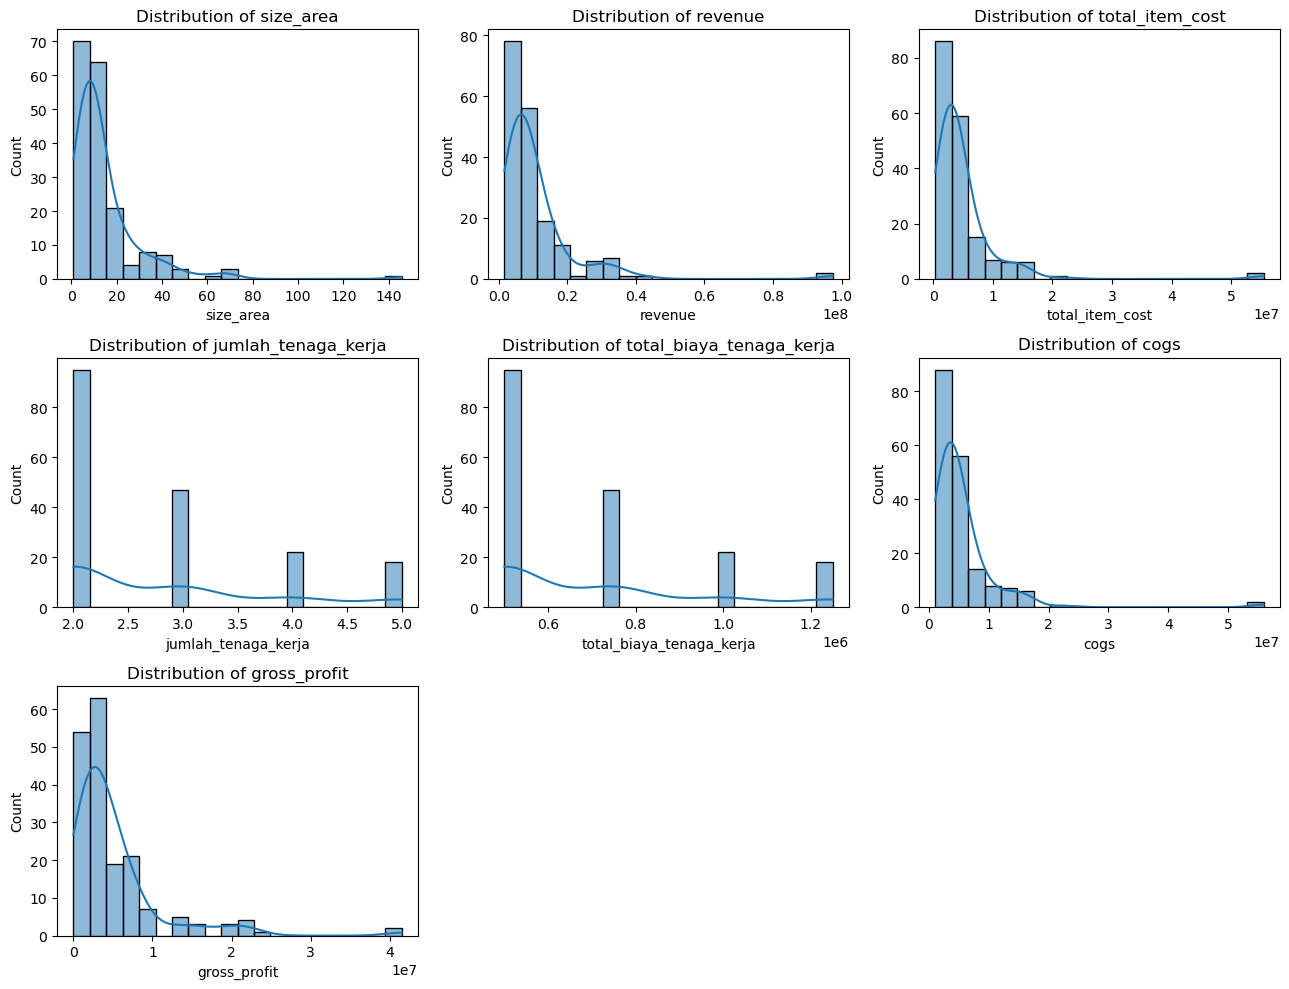

In [44]:
# Menampilkan histogram dengan distribusi dan KDE untuk beberapa kolom dalam dataframe
plt.figure(figsize=(13, 10))

# Plot untuk 'size_area'
plt.subplot(3, 3, 1)
sns.histplot(df['size_area'], bins=20, kde=True)
plt.title('Distribution of size_area')

# Plot untuk 'revenue'
plt.subplot(3, 3, 2)
sns.histplot(df['revenue'], bins=20, kde=True)
plt.title('Distribution of revenue')

# Plot untuk 'total_item_cost'
plt.subplot(3, 3, 3)
sns.histplot(df['total_item_cost'], bins=20, kde=True)
plt.title('Distribution of total_item_cost')

# Plot untuk 'jumlah_tenaga_kerja'
plt.subplot(3, 3, 4)
sns.histplot(df['jumlah_tenaga_kerja'], bins=20, kde=True)
plt.title('Distribution of jumlah_tenaga_kerja')

# Plot untuk 'total_biaya_tenaga_kerja'
plt.subplot(3, 3, 5)
sns.histplot(df['total_biaya_tenaga_kerja'], bins=20, kde=True)
plt.title('Distribution of total_biaya_tenaga_kerja')

# Plot untuk 'cogs'
plt.subplot(3, 3, 6)
sns.histplot(df['cogs'], bins=20, kde=True)
plt.title('Distribution of cogs')

# Plot untuk 'gross_profit'
plt.subplot(3, 3, 7)
sns.histplot(df['gross_profit'], bins=20, kde=True)
plt.title('Distribution of gross_profit')

# Atur layout dan tampilkan plot
plt.tight_layout()
plt.show()

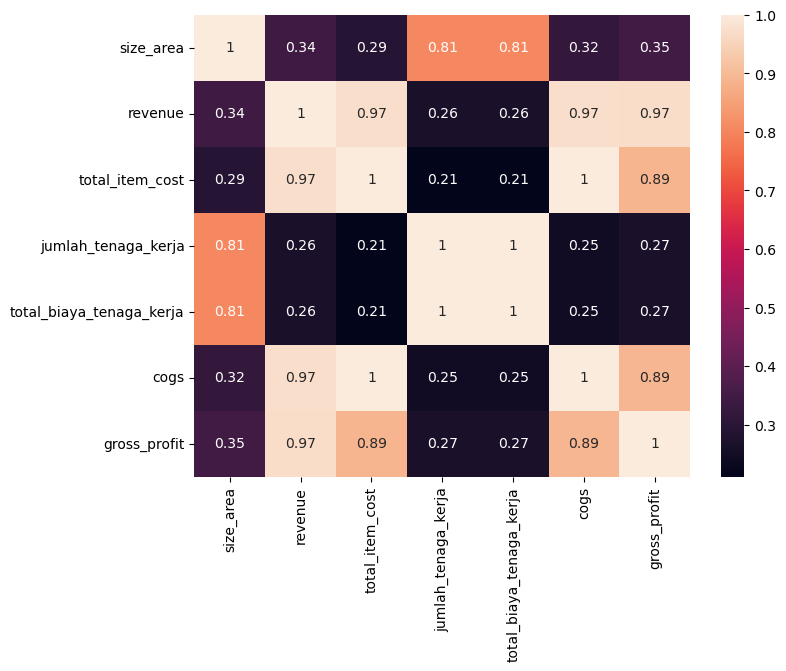

In [45]:
# Menampilkan heatmap korelasi antar kolom numerik yang relevan
plt.figure(figsize=(8,6))
sns.heatmap(df[["size_area", "revenue", "total_item_cost", "jumlah_tenaga_kerja", "total_biaya_tenaga_kerja", "cogs", "gross_profit"]].corr(), annot=True)
plt.show()

# Insight

### Tren order pembuatan taman dari waktu ke waktu berdasarkan lokasi

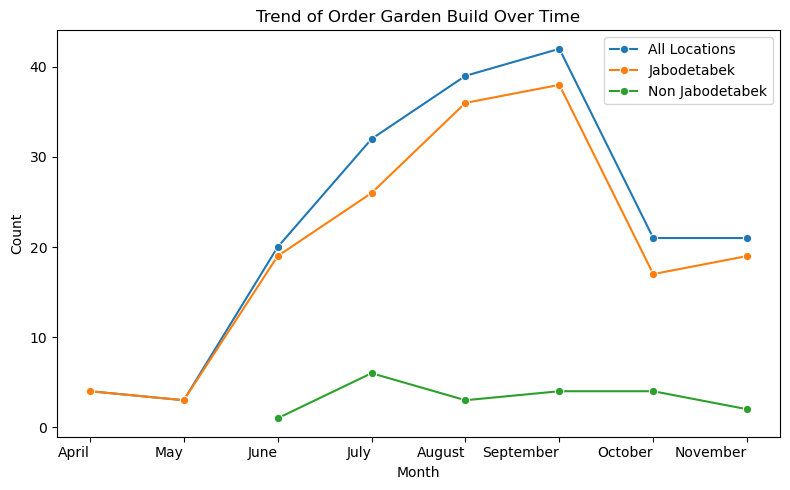

In [41]:
# Menambahkan kolom 'month' berdasarkan tanggal
df['month'] = df['date'].dt.to_period('M')

# Menghitung jumlah pesanan per bulan untuk semua lokasi
monthly_orders = df.groupby('month')['id_order'].count()

# Daftar kota Jabodetabek
jabodetabek_cities = ['Jakarta', 'Bogor', 'Depok', 'Tangerang', 'Bekasi',
                       'Jakarta Barat', 'Jakarta Utara', 'Jakarta Timur', 'Jakarta Selatan',
                       'Tangerang Selatan', 'Kabupaten Tangerang', 'Kabupaten Bekasi']

# Menghitung jumlah pesanan per bulan untuk Jabodetabek
jabodetabek_orders = df[df['city'].isin(jabodetabek_cities)].groupby('month')['id_order'].count()

# Menghitung jumlah pesanan per bulan untuk luar Jabodetabek
outside_jabodetabek_orders = df[~df['city'].isin(jabodetabek_cities)].groupby('month')['id_order'].count()

# Plot trend jumlah pesanan
plt.figure(figsize=(8, 5))
sns.lineplot(x=monthly_orders.index.astype(str), y=monthly_orders.values, label='All Locations', marker='o')
sns.lineplot(x=jabodetabek_orders.index.astype(str), y=jabodetabek_orders.values, label='Jabodetabek', marker='o')
sns.lineplot(x=outside_jabodetabek_orders.index.astype(str), y=outside_jabodetabek_orders.values, label='Non Jabodetabek', marker='o')

# Menampilkan nama bulan pada x-axis
month_names = [period.strftime('%B') for period in monthly_orders.index]
plt.xticks(range(len(month_names)), month_names, ha='right')

# Menambahkan label dan judul
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Trend of Order Garden Build Over Time')
plt.legend()

# Atur layout dan tampilkan plot
plt.tight_layout()
plt.show()

Grafik menunjukkan tren jumlah pesanan dari April hingga November untuk tiga kategori yang meliputi All Locations, Jabodetabek, dan Non-Jabodetabek. Puncak jumlah pesanan terjadi pada bulan September, terutama di wilayah Jabodetabek. Tren pesanan di wilayah Non-Jabodetabek relatif stabil, tetapi jumlahnya jauh lebih rendah dibandingkan Jabodetabek. Dapat disimpulkan bahwa Jabodetabek adalah pasar utama, dengan kontribusi paling besar terhadap total pesanan. Untuk meningkatkan jumlah pesanan, fokus bisa diarahkan pada ekspansi di wilayah Non-Jabodetabek.

### Tren pertumbuhan revenue & gross profit dari waktu ke waktu

In [42]:
# Mengelompokkan data berdasarkan bulan dan menghitung total 'gross_profit' dan 'revenue'
monthly_data = df.groupby(pd.Grouper(key='date', freq='M'))[['gross_profit', 'revenue']].sum().reset_index()

# Mengkonversi 'gross_profit' dan 'revenue' menjadi satuan juta
monthly_data['gross_profit'] = monthly_data['gross_profit'] / 1000000
monthly_data['revenue'] = monthly_data['revenue'] / 1000000

# Menampilkan data bulanan
monthly_data

,date,gross_profit,revenue
0,2024-04-30,13.903244,31.623144
1,2024-05-31,14.691662,28.542660
2,2024-06-30,131.335557,307.767789
3,2024-07-31,136.012994,289.372612
4,2024-08-31,202.042987,388.834008
5,2024-09-30,229.605301,462.797240
6,2024-10-31,75.977634,169.069474
7,2024-11-30,127.237704,273.264678


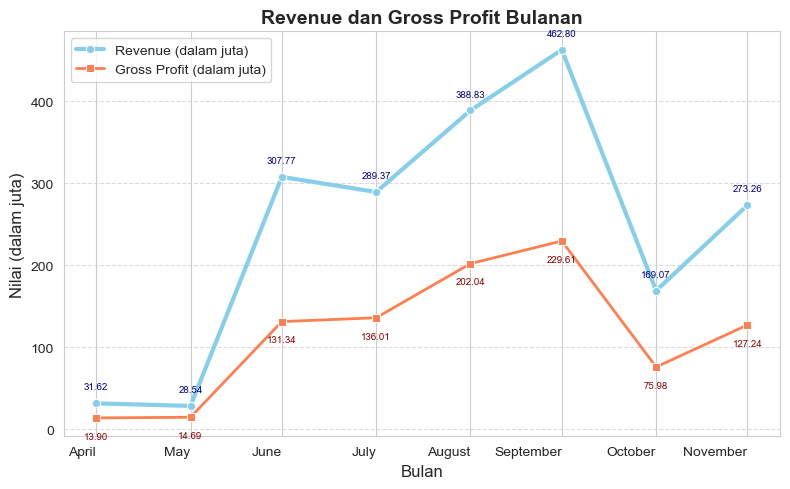

In [43]:
# Membuat plot untuk revenue dan gross profit per bulan
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

# Plot garis untuk revenue
sns.lineplot(x='date', y='revenue', data=monthly_data, label='Revenue (dalam juta)', marker='o', color='skyblue', linewidth=3)

# Plot garis untuk gross profit
sns.lineplot(x='date', y='gross_profit', data=monthly_data, label='Gross Profit (dalam juta)', marker='s', color='coral', linewidth=2)

# Memberikan label pada sumbu x dan y serta judul grafik
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Nilai (dalam juta)', fontsize=12)
plt.title('Revenue dan Gross Profit Bulanan', fontsize=14, fontweight='bold')

# Menambahkan legends dan grid pada sumbu y
plt.legend(loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mengubah kolom date menjadi format datetime
monthly_data['date'] = pd.to_datetime(monthly_data['date'])

# Mengubah format bulan menjadi nama bulan
month_names = monthly_data['date'].dt.strftime('%B')
plt.xticks(monthly_data['date'], month_names, ha='right')

# Menambahkan anotasi pada setiap titik data
for index, row in monthly_data.iterrows():
    plt.annotate(f"{row['revenue']:.2f}", (row['date'], row['revenue']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=7, color='darkblue')
    plt.annotate(f"{row['gross_profit']:.2f}", (row['date'], row['gross_profit']), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=7, color='darkred')

# Menyesuaikan layout dan menampilkan plot
plt.tight_layout()
plt.show()

Grafik menunjukkan pendapatan (revenue) dan profit kotor (gross profit) bulanan dari April hingga November.

Revenue meningkat dari 31,82 juta pada April ke puncak 482,80 juta pada September, lalu turun tajam ke 180,07 juta pada Oktober, dan sedikit naik kembali ke 273,26 juta pada November.

Gross profit juga meningkat dari 13,90 juta pada April ke puncak 220,61 juta pada September, kemudian menurun tajam ke 75,98 juta pada Oktober, dan naik lagi ke 127,24 juta pada November.

Dapat disimpulkan bahwa perusahaan mengalami peningkatan revenue dari bulan April hingga September, tetapi ada penurunan signifikan setelahnya.

### Persentase order pembuatan taman berdasarkan provinsi

In [44]:
province_order_counts = df['province'].value_counts()
province_order_counts

province
Jawa Barat    61
Jakarta       60
Banten        55
Jawa Timur     5
Bali           1
Name: count, dtype: int64

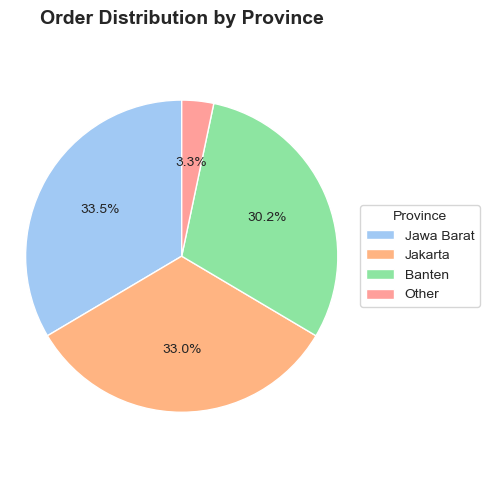

In [45]:
# Menampilkan 3 provinsi dengan jumlah pesanan terbanyak
top_3_provinces = province_order_counts.head(3)

# Menghitung jumlah pesanan dari provinsi lainnya dan menggabungkannya dengan top 3 provinsi
other_provinces_sum = province_order_counts.iloc[3:].sum()
province_order_counts_modified = pd.concat([top_3_provinces, pd.Series({'Other': other_provinces_sum})])

# Membuat pie chart untuk distribusi pesanan berdasarkan provinsi
plt.figure(figsize=(5, 5))
colors = sns.color_palette('pastel')
wedges, texts, autotexts = plt.pie(province_order_counts_modified, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
plt.legend(wedges, province_order_counts_modified.index, title="Province", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Order Distribution by Province', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

Grafik tersebut menunjukkan bahwa secara keseluruhan, tiga provinsi utama (Jawa Barat, Jakarta, dan Banten) mendominasi lebih dari 96% pesanan, sementara kategori "Other" hanya berkontribusi sebesar 3.3% terhadap total pesanan. 

Pesanan terbanyak berasal dari provinsi Jawa Barat dengan 33.5%, diikuti oleh Jakarta dengan 33.0%, dan Banten dengan 30.2%.

Hal ini menunjukkan bahwa fokus pasar atau aktivitas bisnis mungkin terkonsentrasi di ketiga provinsi tersebut.

### Kota dengan orderan pembuatan taman tertinggi

In [46]:
# Menghitung jumlah pesanan per kota
city_order_counts = df['city'].value_counts()
top_10_cities = city_order_counts.head(10)
top_10_cities

city
Bekasi               30
Tangerang Selatan    28
Tangerang            21
Jakarta Selatan      19
Depok                18
Jakarta Timur        12
Jakarta Barat        12
Jakarta Utara         9
Jakarta Pusat         8
Bogor                 6
Name: count, dtype: int64

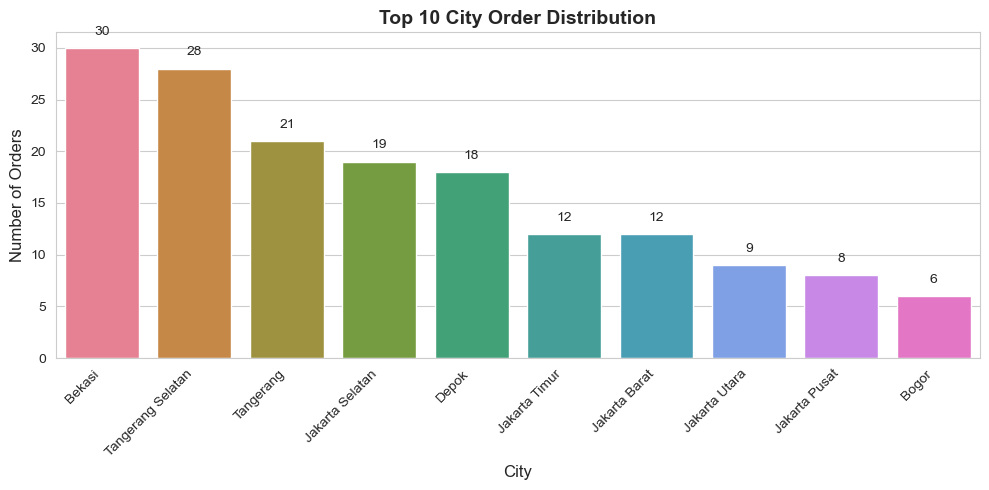

In [47]:
# Menampilkan barplot distribusi pesanan berdasarkan 10 kota teratas
plt.figure(figsize=(10, 5))
colors = sns.color_palette("husl", n_colors=len(top_10_cities))
sns.barplot(x=top_10_cities.index, y=top_10_cities.values, palette=colors)

# Menambahkan angka di atas setiap bar
for i, v in enumerate(top_10_cities.values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)

# Menambahkan label dan judul
plt.xlabel("City", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)
plt.title("Top 10 City Order Distribution", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Grafik tersebut menampilkan jumlah pesanan (order) berdasarkan kota dengan distribusi tertinggi.
Bekasi memimpin dengan 30 order, diikuti oleh Tangerang Selatan (28 order) dan Tangerang (21 order).
Kota dengan jumlah order terendah dalam daftar adalah Bogor dengan 6 order.

Dapat disimpulkan bahwa Bekasi adalah pasar terbesar untuk layanan ini, menunjukkan konsentrasi pelanggan potensial di wilayah tersebut.
Mungkin perlu dilakukan strategi pemasaran tambahan di kota dengan jumlah order lebih rendah, seperti Bogor dan Jakarta Pusat, untuk meningkatkan penetrasi pasar.

### Gardener dengan total biaya tenaga kerja tertinggi

In [48]:
# Menghitung total biaya tenaga kerja untuk setiap gardener, mengecualikan nama 'none'
gardener_labor_cost = df[df['name'] != 'none'].groupby('name')['total_biaya_tenaga_kerja'].sum().sort_values(ascending=False)
gardener_labor_cost

name
Ari aryana        27500000
Budi Wahyudi      25250000
ODIH              24250000
Abdul mujid       11500000
Roni sihanturi    10250000
Wandi obos         9500000
Wahyu Alvian       5500000
Martin             2000000
Ravi               1750000
Enjam jamhari      1000000
Name: total_biaya_tenaga_kerja, dtype: int64

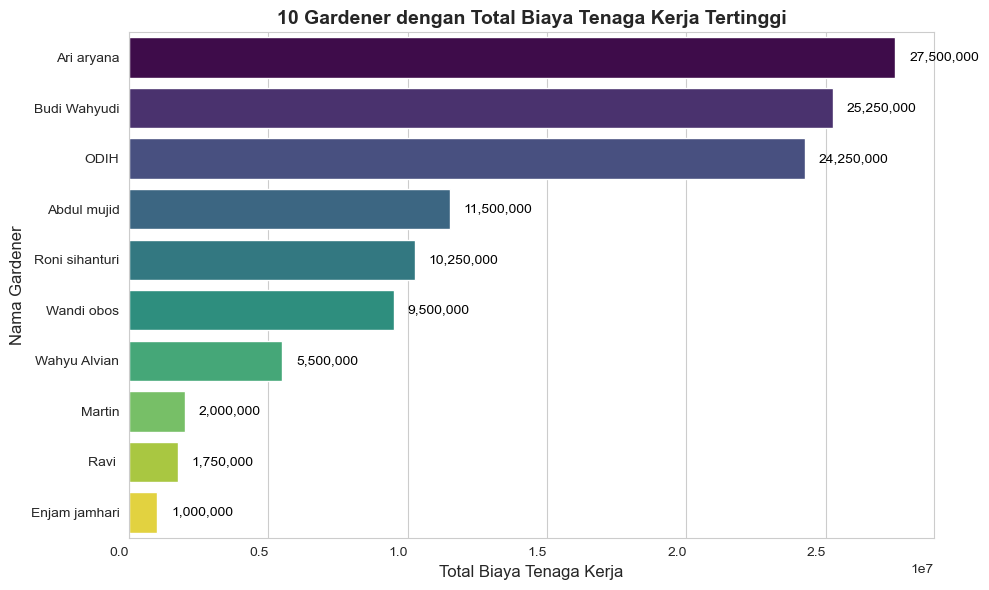

In [49]:
# Membuat barplot untuk 10 gardener dengan total biaya tenaga kerja tertinggi
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(gardener_labor_cost[:10])))
sns.barplot(y=gardener_labor_cost.index[:10], x=gardener_labor_cost.values[:10], palette=colors)

# Menambahkan label dan judul
plt.xticks(ha='right')
plt.xlabel("Total Biaya Tenaga Kerja", fontsize=12)
plt.ylabel("Nama Gardener", fontsize=12)
plt.title("10 Gardener dengan Total Biaya Tenaga Kerja Tertinggi", fontsize=14, fontweight='bold')

# Menambahkan label angka pada setiap bar
for i, v in enumerate(gardener_labor_cost.values[:10]):
    plt.text(v + 500000, i, f"{v:,}", color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()

Grafik tersebut menampilkan daftar 10 gardener dengan total biaya tenaga kerja tertinggi. Ari Aryana adalah gardener dengan biaya tenaga kerja tertinggi sebesar 27.500.000, diikuti oleh Budi Wahyudi (25.250.000) dan ODIH (24.250.000). Gardener dengan biaya tenaga kerja terendah dalam daftar ini adalah Enjam Jamhari dengan 1.000.000.

Dapat disimpulkan bahwa biaya tenaga kerja memiliki distribusi yang signifikan di antara gardener. Ini menunjukkan adanya perbedaan tingkat pengalaman atau keterampilan di antara gardener. Gardener dengan biaya tinggi mungkin lebih sering menangani proyek kompleks atau memiliki keahlian khusus.

# Conclusion

**1. Dominasi Wilayah Jabodetabek sebagai Pasar**
   - Jabodetabek memberikan kontribusi terbesar terhadap jumlah pesanan dan pendapatan. Tren pesanan di wilayah ini menunjukkan peningkatan signifikan hingga September, dengan puncak pesanan di bulan tersebut.
   - Wilayah Non-Jabodetabek memiliki jumlah pesanan yang jauh lebih rendah dengan tren stabil. Strategi ekspansi perlu difokuskan untuk meningkatkan kontribusi dari wilayah ini.
     
**2. Kinerja Pendapatan dan Gross Profit**
   - Pendapatan dan profit kotor mencapai puncaknya pada bulan September, tetapi mengalami penurunan signifikan pada bulan Oktober. Hal ini menunjukkan bahwa meskipun ada momentum kuat di awal, perusahaan menghadapi tantangan dalam mempertahankan kinerja setelah September. Penurunan ini dapat diatasi dengan strategi untuk meningkatkan efisiensi atau diversifikasi pasar.
     
**3. Konsentrasi Pasar di Tiga Provinsi Utama**
   - Jawa Barat, Jakarta, dan Banten mendominasi lebih dari 96% pesanan. Hal ini menunjukkan bahwa aktivitas bisnis sangat terkonsentrasi di tiga provinsi ini. Perlu dilakukan eksplorasi lebih lanjut untuk memperluas jangkauan ke wilayah lain guna mengurangi ketergantungan pada pasar utama.
     
**4. Bekasi sebagai Kota dengan Potensi Pasar Tertinggi**
   - Bekasi memimpin dalam jumlah pesanan, diikuti oleh Tangerang Selatan dan Tangerang. Namun, kota dengan pesanan lebih rendah seperti Bogor dan Jakarta Pusat dapat menjadi target strategi pemasaran tambahan untuk meningkatkan penetrasi pasar.
     
**5. Distribusi Biaya Tenaga Kerja Gardener**
   - Perbedaan signifikan dalam biaya tenaga kerja di antara gardener menunjukkan adanya variasi tingkat keahlian atau pengalaman. Gardener dengan biaya tinggi, seperti Ari Aryana, mungkin memiliki kompetensi khusus atau sering menangani proyek kompleks. Perusahaan dapat mempertimbangkan pengelolaan gardener secara lebih strategis untuk memaksimalkan efisiensi dan kepuasan pelanggan.

**Saran:**
- Fokus pada ekspansi wilayah Non-Jabodetabek untuk menyeimbangkan distribusi pesanan.
- Tingkatkan strategi pemasaran di kota-kota dengan jumlah pesanan rendah untuk mengoptimalkan penetrasi pasar.
- Identifikasi dan mitigasi faktor yang menyebabkan penurunan pendapatan dan profit kotor setelah September.
- Manfaatkan gardener dengan keahlian tinggi untuk proyek-proyek besar sekaligus memberikan pelatihan bagi gardener lainnya untuk meningkatkan keterampilan dan efisiensi.